# Why ExoJAX Prefers On-Demand Opacity Calculation?

Last Update: January 23rd (2025) Hajime Kawahara

One of ExoJAX's key features is its ability to compute molecular cross-sections on demand by reading the latest molecular databases, rather than relying on pre-generated table data. Here, we explain the rationale behind this strategy. 


The following outlines the standard procedure for calculating cross-sections in ExoJAX. First, define the wavenumber range ([utils.grid.wavenumber_grid](../exojax/exojax.utils.html#exojax.utils.grids.wavenumber_grid)), then load the molecular database ([Molecular and Atomic Databases](../userguide/mdb.html)). Next, create an instance specifying the method for computing opacity ([Opacity Calculator Class](userguide/opacalc.html)). There are several options for opacity calculation methods, depending on factors such as the number of lines. Finally, by providing temperature and pressure, the cross-section can be calculated.

Currently, molecular databases such as ExoMol and HITRAN/HITEMP are continuously being improved. ExoJAX's ability to compute cross-sections directly from the molecular database level offers the advantage of always utilizing the latest versions of these databases.

xsmode =  lpf
xsmode assumes ESLOG in wavenumber space: xsmode=lpf
The wavenumber grid should be in ascending order.
The users can specify the order of the wavelength grid by themselves.
Your wavelength grid is in ***  descending  *** order
HITRAN exact name= (12C)(16O)
radis engine =  vaex


/home/kawahara/exojax/src/exojax/spec/unitconvert.py:63: UserWarning: Both input wavelength and output wavenumber are in ascending order.
  warnings.warn(
/home/kawahara/exojax/src/exojax/utils/molname.py:197: FutureWarning: e2s will be replaced to exact_molname_exomol_to_simple_molname.
  warnings.warn(
/home/kawahara/exojax/src/exojax/utils/molname.py:91: FutureWarning: exojax.utils.molname.exact_molname_exomol_to_simple_molname will be replaced to radis.api.exomolapi.exact_molname_exomol_to_simple_molname.
  warnings.warn(
/home/kawahara/exojax/src/exojax/utils/molname.py:91: FutureWarning: exojax.utils.molname.exact_molname_exomol_to_simple_molname will be replaced to radis.api.exomolapi.exact_molname_exomol_to_simple_molname.
  warnings.warn(


Molecule:  CO
Isotopologue:  12C-16O
Background atmosphere:  H2
ExoMol database:  None
Local folder:  .database/CO/12C-16O/Li2015
Transition files: 
	 => File 12C-16O__Li2015.trans
Broadening code level: a0


/home/kawahara/anaconda3/lib/python3.10/site-packages/radis-0.15.2-py3.10.egg/radis/api/exomolapi.py:685: AccuracyWarning: The default broadening parameter (alpha = 0.07 cm^-1 and n = 0.5) are used for J'' > 80 up to J'' = 152
  warnings.warn(


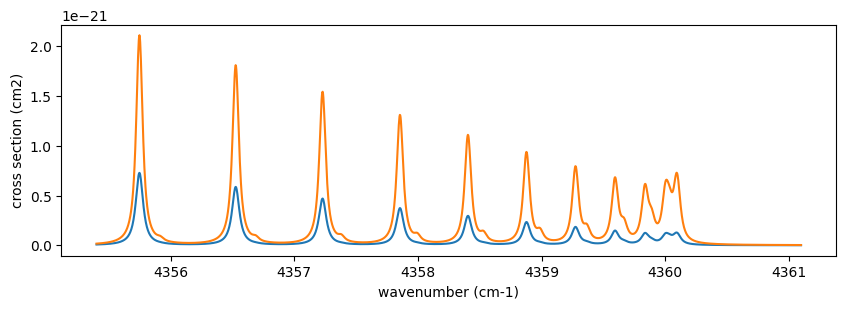

In [1]:
import matplotlib.pyplot as plt
from exojax.utils.grids import wavenumber_grid
from exojax.spec.api import MdbExomol
from exojax.spec.opacalc import OpaDirect

nu_grid, wav, res = wavenumber_grid(22930, 22960, 2000, xsmode="lpf", unit="AA")
mdb = MdbExomol('.database/CO/12C-16O/Li2015', nurange=nu_grid)
opa = OpaDirect(mdb, nu_grid)

t0 = 900.0 #K
t1 = 1200.0 #K
p0 = 1.e0 #bar

xs_t0 = opa.xsvector(t0,p0)
xs_t1 = opa.xsvector(t1,p0)

fig = plt.figure(figsize=(10,3))
plt.plot(nu_grid,xs_t0,label="T="+str(t0)+"K")
plt.plot(nu_grid,xs_t1,label="T="+str(t0)+"1200K")
plt.xlabel("wavenumber (cm-1)")
plt.ylabel("cross section (cm2)")
plt.show()

In addition to the benefits of allowing users to always utilize the latest molecular databases and track the assumptions and methods used to compute cross-sections, on-demand computation also eliminates interpolation errors inherent in table-based data. Let’s examine this error with a simple example.

When calculating opacity using precomputed table data, it is necessary to interpolate cross-sections from neighboring temperature grid points to obtain the cross-section at the desired temperature and pressure. Here, we fix the pressure at 1 bar and compare the interpolated cross-section at an intermediate temperature `tc`, derived from the cross-sections at 900 K and 1200 K, with the cross-section directly calculated at `tc`. For the direct calculation at the intermediate temperature, we will compare two approaches: the arithmetic mean and the logarithmic mean.For interpolating the cross-sections, let’s consider two approaches: the arithmetic mean and the logarithmic mean.

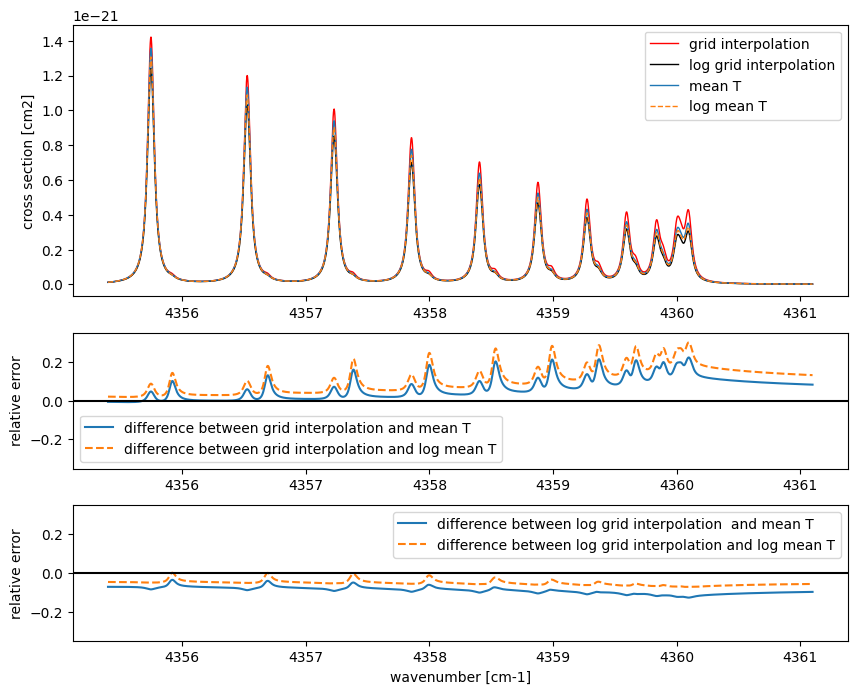

In [13]:
import numpy as np

t0 = 900.0
t1 = 1200.0
tc = (t1 + t0) / 2.0  # linear interpolation
tc_log = 10 ** ((np.log10(t1) + np.log10(t0)) / 2.0)  # log interpolation

xs00 = opa.xsvector(t0, p0)
xs10 = opa.xsvector(t1, p0)

# grid interpolation (mean and log mean)
averaged_xs = (xs00 + xs10) / 2.0
averaged_xs_log = 10**((np.log10(xs00) + np.log10(xs10)) / 2.0)


#direct calculation
xs = opa.xsvector(tc, p0)
xs_log = opa.xsvector(tc_log, p0)

f, (ax, ax2, ax3) = plt.subplots(3, 1, gridspec_kw={"height_ratios": [2, 1, 1]}, figsize=(10, 8))

ax.plot(nu_grid, averaged_xs, label="grid interpolation", lw=1, color="red")
ax.plot(nu_grid, averaged_xs_log, label="log grid interpolation", lw=1, color="black")

ax.plot(nu_grid, xs, label="mean T", ls="solid", lw=1)
ax.plot(nu_grid, xs_log, label="log mean T", ls="dashed", lw=1)

ax2.plot(nu_grid, averaged_xs / xs - 1.0, label="difference between grid interpolation and mean T", ls="solid") 
ax2.plot(nu_grid, averaged_xs / xs_log - 1.0, label="difference between grid interpolation and log mean T", ls="dashed")

ax3.plot(nu_grid, averaged_xs_log / xs - 1.0, label="difference between log grid interpolation  and mean T", ls="solid") 
ax3.plot(nu_grid, averaged_xs_log / xs_log - 1.0, label="difference between log grid interpolation and log mean T", ls="dashed")


ax.legend()
ax2.set_ylim(-0.35, 0.35)
ax2.legend()
ax2.axhline(0.0, color="k")

ax3.set_ylim(-0.35, 0.35)
ax3.legend()
ax3.axhline(0.0, color="k")

ax.set_ylabel("cross section [cm2]")
ax3.set_xlabel("wavenumber [cm-1]")
ax2.set_ylabel("relative error")
ax3.set_ylabel("relative error")
plt.show()

With a temperature grid of 300 K intervals, the arithmetic mean introduces an error of about 20–30%, while the logarithmic mean reduces the error to about 5–10%. If table data is used, it would be better to perform interpolation in this case using logarithmic values for both temperature and cross-sections. A noteworthy point is that, whether using the arithmetic mean or the logarithmic mean, the relative error is consistently either positive or negative across all wavenumbers. This suggests that the error originates from the line strength and indicates that it could serve as a source of systematic error, even in cases with low spectral resolution.

Next, let’s consider the case of fixing the temperature at 900 K and interpolating the pressure. Since pressure has a high dynamic range, it is necessary to use a logarithmic grid. Here, we will interpolate using 1 bar and 10 bar as the grid points.

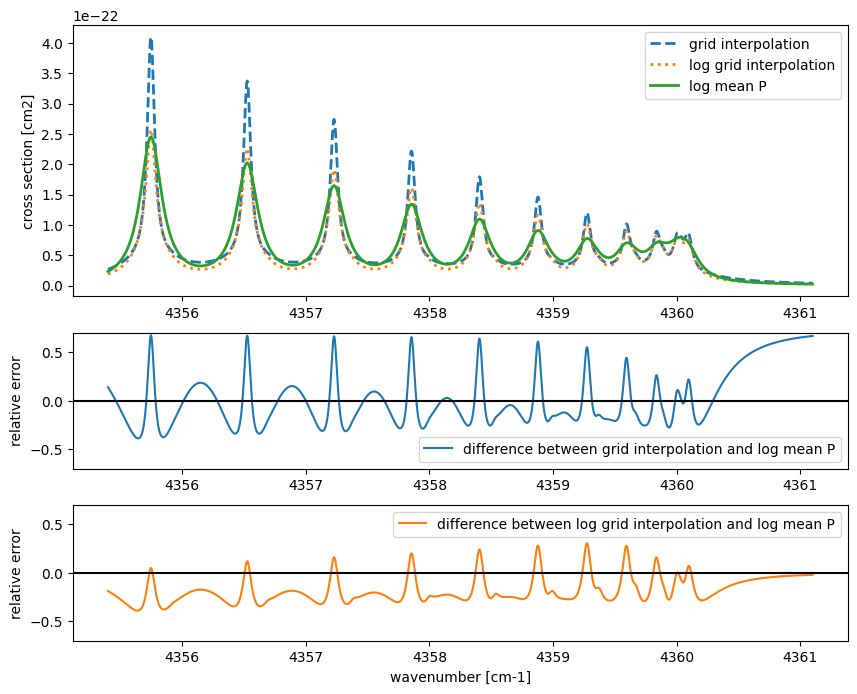

In [10]:
t0 = 900.0
p0 = 1.e0
p1 = 1.e1
pc_log = 10 ** ((np.log10(p1) + np.log10(p0)) / 2.0)  # log interpolation

xs00 = opa.xsvector(t0, p0)
xs01 = opa.xsvector(t0, p1)

# grid interpolation (mean and log mean)
averaged_xs = (xs00 + xs01) / 2.0
averaged_xs_log = 10**((np.log10(xs00) + np.log10(xs01)) / 2.0)


#direct calculation
xs = opa.xsvector(t0, pc_log)

f, (ax, ax2, ax3) = plt.subplots(3, 1, gridspec_kw={"height_ratios": [2, 1, 1]}, figsize=(10, 8))

ax.plot(nu_grid, averaged_xs, label="grid interpolation", lw=2, color="C0", ls="dashed")
ax.plot(nu_grid, averaged_xs_log, label="log grid interpolation", lw=2, color="C1", ls="dotted")

ax.plot(nu_grid, xs, label="log mean P", ls="solid", lw=2, color="C2")
ax2.plot(nu_grid, averaged_xs / xs - 1.0, label="difference between grid interpolation and log mean P", ls="solid", color="C0") 
ax3.plot(nu_grid, averaged_xs_log / xs - 1.0, label="difference between log grid interpolation and log mean P", ls="solid", color="C1") 


ax.legend()
ax2.set_ylim(-0.7, 0.7)
ax2.legend()
ax2.axhline(0.0, color="k")

ax3.set_ylim(-0.7, 0.7)
ax3.legend()
ax3.axhline(0.0, color="k")

ax.set_ylabel("cross section [cm2]")
ax3.set_xlabel("wavenumber [cm-1]")
ax2.set_ylabel("relative error")
ax3.set_ylabel("relative error")
plt.show()

When interpolating pressure, the tail of the line profile is affected, leading to a different error profile compared to temperature interpolation. Since line strength remains unchanged during pressure interpolation, the impact may be relatively minor for cases without high-resolution spectroscopy.

As shown, using precomputed table data can introduce non-negligible errors in cross-section calculations, especially for high-resolution spectra. While narrowing the grid intervals can mitigate this issue, it leads to increased memory usage. To address this problem, ExoJAX aims to compute cross-sections on demand for the given temperature and pressure. Additionally, for cases where lower precision is acceptable, table data can still be generated and utilized as needed.